# My first pyspark notebook


For windows, follow the install instructions at: https://medium.com/@GalarnykMichael/install-spark-on-windows-pyspark-4498a5d8d66c

For an ubuntu install on an EC2 instance: https://medium.com/@josemarcialportilla/getting-spark-python-and-jupyter-notebook-running-on-amazon-ec2-dec599e1c297


## 0. Start a SparkContext()

or launch pyspark from the Command Prompt: pyspark --master local[*]


In [1]:
from pyspark import SparkContext
sc = SparkContext()

# 1. Spark Core: Manipulate a first RDD (Resilient Distributed Dataset)¶

In [2]:
# Create an RDD (~list of list where you can store any type)
rdd1 = sc.parallelize(["Boston, 24, 09-07-2007","Cambridge, 25, 06-05-2008","New York, 28, 03-27-2011", "Paris, 28, 06-05-2011"])

# Apply a first transformation (function that transform an RDD into another RDD): map
rdd2 = rdd1.map(lambda x: x.split(","))

# Apply a filter (on rows)
rdd3 = rdd2.filter(lambda x: 'Paris' in x)

# Print
rdd3.collect()

[['Paris', ' 28', ' 06-05-2011']]

In [3]:
# Apply a first action (function returning a result): count 

print rdd1.count()
print rdd2.count()
print rdd3.count()

4
4
1


In [4]:
# Apply another action: reduce 

rdd = sc.parallelize([5,6,7])
print rdd.collect()
rdd.reduce(lambda x,y: x+y)

[5, 6, 7]


18

## 2. Spark SQL: Spark's DataFrame

In [5]:
from pyspark.sql import SQLContext

sqlcontext = SQLContext(sc)

In [6]:
# Create RDD
rdd = sc.parallelize(["Boston, 24, 09-07-2007","Cambridge, 25, 06-05-2008","New York, 28, 03-27-2011", "Paris, 28, 06-05-2011"])
rdd = rdd.map(lambda x: x.split(","))

#Create DataFrame from RDD
df = sqlcontext.createDataFrame(rdd, ["City", "Age", "Date"])
df.collect()

[Row(City=u'Boston', Age=u' 24', Date=u' 09-07-2007'),
 Row(City=u'Cambridge', Age=u' 25', Date=u' 06-05-2008'),
 Row(City=u'New York', Age=u' 28', Date=u' 03-27-2011'),
 Row(City=u'Paris', Age=u' 28', Date=u' 06-05-2011')]

In [7]:
# Use select to select columns
df.select(['City',"Date"]).collect()

[Row(City=u'Boston', Date=u' 09-07-2007'),
 Row(City=u'Cambridge', Date=u' 06-05-2008'),
 Row(City=u'New York', Date=u' 03-27-2011'),
 Row(City=u'Paris', Date=u' 06-05-2011')]

In [8]:
# Like Pandas' DataFrame, we can select a column like an attribute
df.City

Column<City>

In [9]:
# We use filter to select some rows
df.filter(df.City == 'Cambridge').collect()

[Row(City=u'Cambridge', Age=u' 25', Date=u' 06-05-2008')]

## 2. Compute Pi

https://spark.apache.org/examples.html

This code estimates $π$ by "throwing darts" at a circle. We pick random points in the unit square ((0, 0) to (1,1)) and see how many fall in the unit circle. The fraction should be $π$ / 4, so we use this to get our estimate.

### 2.1. Without Spark

In [10]:
import time
import random

num_samples = 1000000

def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1

start = time.time()

count = []
for i in range(num_samples):
    count.append(inside(1))

pi = 4 * sum(count) / (num_samples+0.0)
print pi

print "Without Spark, simulating", num_samples, "samples takes", round(time.time()-start,0), "seconds"


3.142768
Without Spark, simulating 1000000 samples takes 0.0 seconds


### 2.2. With Spark

In [11]:
start = time.time()

count = sc.parallelize(range(0, num_samples)).filter(inside).count()

pi = 4 * count / (num_samples+0.0)
print(pi)

print "With Spark, simulating", num_samples, "samples takes", round(time.time()-start,0), "seconds"


3.138508
With Spark, simulating 1000000 samples takes 1.0 seconds


Using spark for small tasks is not always faster than regular Python code. 

### 2.3. Visualization

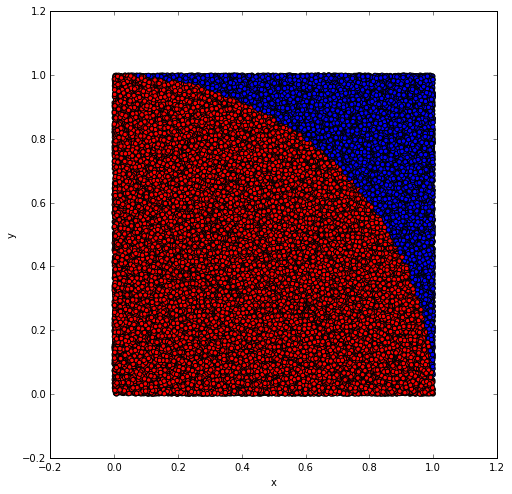

In [12]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

num_samples = 100000

def inside(p):     
  x, y = random.random(), random.random()
  return [x, y, x*x + y*y < 1]

l = []
for i in range(num_samples):
    l.append(inside(1))

df_l = pd.DataFrame(l, columns=['x','y','inside?'])

colors = {True:'red', False:'blue'}
df_l.plot.scatter(x = 'x', y = 'y', c = df_l['inside?'].apply(lambda x: colors[x]), figsize=(8,8))
plt.show()

# 3. Statistics with MLlib

https://spark.apache.org/docs/latest/mllib-statistics.html

## 3.1. Basic column summary statistics

In [21]:
import numpy as np
from pyspark.mllib.stat import Statistics

mat = sc.parallelize(
    [np.array([1.0, 10.0, 100.0]), np.array([2.0, 20.0, 200.0]), np.array([3.0, 30.0, 300.0])]
) 

# Compute column summary statistics.
summary = Statistics.colStats(mat)
print "Mean value for each column:", summary.mean()
print "Variance for each column:", summary.variance()
print "Number of non-zeros for each column:", summary.numNonzeros()

Mean value for each column: [   2.   20.  200.]
Variance for each column: [  1.00000000e+00   1.00000000e+02   1.00000000e+04]
Number of non-zeros for each column: [ 3.  3.  3.]


## 3.2 Correlation

In [29]:
# Correlation on 2 series
seriesX = sc.parallelize([1.0, 2.0, 3.0, 3.0, 5.0]) 
seriesY = sc.parallelize([11.0, 22.0, 33.0, 33.0, 555.0])

print "Correlation of the 2 series is: " + str(Statistics.corr(seriesX, seriesY, method="pearson")) + '\n' #Use "spearman" for Spearman's method.

#Correlation on an RDD of vectors
data = sc.parallelize(
    [np.array([1.0, 10.0, 100.0]), np.array([2.0, 20.0, 200.0]), np.array([5.0, 33.0, 366.0])]
)  

print "Correlation matrix of the RDD: \n ", Statistics.corr(data, method="pearson")

Correlation of the 2 series is: 0.850028676877

Correlation matrix of the RDD: 
  [[ 1.          0.97888347  0.99038957]
 [ 0.97888347  1.          0.99774832]
 [ 0.99038957  0.99774832  1.        ]]


## 3.3. Chi-Square 'Goodness-of-the-fit' test

In [31]:
from pyspark.mllib.linalg import Matrices, Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics

vec = Vectors.dense(0.1, 0.15, 0.2, 0.3, 0.25)  # a vector composed of the frequencies of events

# compute the goodness of fit. If a second vector to test against
# is not supplied as a parameter, the test runs against a uniform distribution.
goodnessOfFitTestResult = Statistics.chiSqTest(vec)

# summary of the test including the p-value, degrees of freedom,
# test statistic, the method used, and the null hypothesis.
print("%s\n" % goodnessOfFitTestResult)

mat = Matrices.dense(3, 2, [1.0, 3.0, 5.0, 2.0, 4.0, 6.0])  # a contingency matrix

# conduct Pearson's independence test on the input contingency matrix
independenceTestResult = Statistics.chiSqTest(mat)

# summary of the test including the p-value, degrees of freedom,
# test statistic, the method used, and the null hypothesis.
print("%s\n" % independenceTestResult)

obs = sc.parallelize(
    [LabeledPoint(1.0, [1.0, 0.0, 3.0]),
     LabeledPoint(1.0, [1.0, 2.0, 0.0]),
     LabeledPoint(1.0, [-1.0, 0.0, -0.5])]
)  # LabeledPoint(feature, label)

# The contingency table is constructed from an RDD of LabeledPoint and used to conduct
# the independence test. Returns an array containing the ChiSquaredTestResult for every feature
# against the label.
featureTestResults = Statistics.chiSqTest(obs)

for i, result in enumerate(featureTestResults):
    print("Column %d:\n%s" % (i + 1, result))

Chi squared test summary:
method: pearson
degrees of freedom = 4 
statistic = 0.12499999999999999 
pValue = 0.998126379239318 
No presumption against null hypothesis: observed follows the same distribution as expected..

Chi squared test summary:
method: pearson
degrees of freedom = 2 
statistic = 0.14141414141414144 
pValue = 0.931734784568187 
No presumption against null hypothesis: the occurrence of the outcomes is statistically independent..

Column 1:
Chi squared test summary:
method: pearson
degrees of freedom = 0 
statistic = 0.0 
pValue = 1.0 
No presumption against null hypothesis: the occurrence of the outcomes is statistically independent..
Column 2:
Chi squared test summary:
method: pearson
degrees of freedom = 0 
statistic = 0.0 
pValue = 1.0 
No presumption against null hypothesis: the occurrence of the outcomes is statistically independent..
Column 3:
Chi squared test summary:
method: pearson
degrees of freedom = 0 
statistic = 0.0 
pValue = 1.0 
No presumption against n

## 3.3. Kolmogorov-Smirnov 'Goodness-of-the-fit' test

In [32]:
from pyspark.mllib.stat import Statistics

parallelData = sc.parallelize([0.1, 0.15, 0.2, 0.3, 0.25])

# run a KS test for the sample versus a standard normal distribution
testResult = Statistics.kolmogorovSmirnovTest(parallelData, "norm", 0, 1)
# summary of the test including the p-value, test statistic, and null hypothesis
# if our p-value indicates significance, we can reject the null hypothesis
# Note that the Scala functionality of calling Statistics.kolmogorovSmirnovTest with
# a lambda to calculate the CDF is not made available in the Python API
print(testResult)

Kolmogorov-Smirnov test summary:
degrees of freedom = 0 
statistic = 0.539827837277029 
pValue = 0.06821463111921133 
Low presumption against null hypothesis: Sample follows theoretical distribution.


## 3.4. Random data generation

In [36]:
from pyspark.mllib.random import RandomRDDs

# Generate a random double RDD that contains 1 million i.i.d. values drawn from the
# standard normal distribution `N(0, 1)`, evenly distributed in 10 partitions.
u = RandomRDDs.normalRDD(sc, 1000000L, 10)
# Apply a transform to get a random double RDD following `N(1, 4)`.
v = u.map(lambda x: 1.0 + 2.0 * x)
print u

MapPartitionsRDD[144] at mapPartitions at PythonMLLibAPI.scala:1323
